In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


In [2]:
train = pd.read_csv("../data/raw/train(1).csv")

print("Tabular data shape:", train.shape)
train.head()


Tabular data shape: (16209, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [3]:
img_df = pd.read_csv("../data/processed/image_features.csv")

print("Image features shape:", img_df.shape)
img_df.head()


Image features shape: (16209, 8)


,r_mean,g_mean,b_mean,brightness,ndvi_proxy,entropy,id,price
0,35.986082,38.411316,28.883317,34.426905,0.032598,6.184453,9117000170,268643
1,37.824665,39.761728,30.461106,36.015833,0.024967,6.174767,6700390210,245000
2,34.354182,37.469049,27.344721,33.055984,0.043369,6.261249,7212660540,200000
3,17.323004,23.909806,15.519533,18.917448,0.159747,5.300774,8562780200,352499
4,26.950853,29.982751,21.341142,26.091582,0.053253,5.964189,7760400350,232000


In [4]:
df = train.merge(img_df, on="id", how="inner")

print("Merged dataset shape:", df.shape)
df.head()


Merged dataset shape: (16407, 28)


,id,date,price_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,r_mean,g_mean,b_mean,brightness,ndvi_proxy,entropy,price_y
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,-122.187,1660,9240,35.986082,38.411316,28.883317,34.426905,0.032598,6.184453,268643
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,-122.187,1720,3605,37.824665,39.761728,30.461106,36.015833,0.024967,6.174767,245000
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,-122.313,1870,7455,34.354182,37.469049,27.344721,33.055984,0.043369,6.261249,200000
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,-122.073,1240,750,17.323004,23.909806,15.519533,18.917448,0.159747,5.300774,352499
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,-122.074,1590,8071,26.950853,29.982751,21.341142,26.091582,0.053253,5.964189,232000


In [5]:
df = df.rename(columns={"price_x": "price"})
df[["price", "r_mean", "g_mean", "ndvi_proxy"]].head()


,price,r_mean,g_mean,ndvi_proxy
0,268643,35.986082,38.411316,0.032598
1,245000,37.824665,39.761728,0.024967
2,200000,34.354182,37.469049,0.043369
3,352499,17.323004,23.909806,0.159747
4,232000,26.950853,29.982751,0.053253


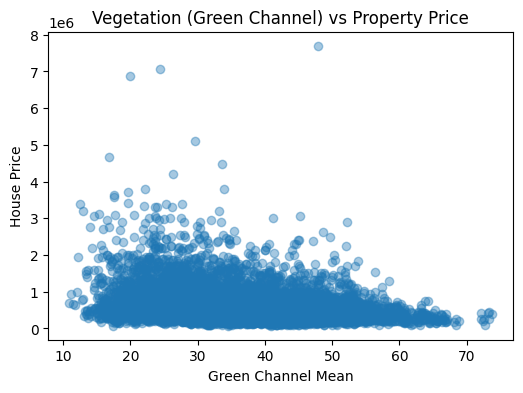

In [6]:
plt.figure(figsize=(6,4))
plt.scatter(df["g_mean"], df["price"], alpha=0.4)
plt.xlabel("Green Channel Mean")
plt.ylabel("House Price")
plt.title("Vegetation (Green Channel) vs Property Price")
plt.show()


In [7]:
df["log_price"] = np.log1p(df["price"])
y = df["log_price"]



In [8]:
tab_features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
    'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
    'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'
]

In [9]:
image_features = [
    "r_mean", "g_mean", "b_mean",
    "brightness", "entropy", "ndvi_proxy"
]


In [10]:
X = df[tab_features + image_features]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
# rf_multi = RandomForestRegressor(
#     n_estimators=400,
#     max_depth=25,
#     random_state=42,
#     n_jobs=-1
# )

# rf_multi.fit(X_train, y_train)


In [13]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


In [14]:
model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [15]:
y_pred_multi = model.predict(X_val)

rmse_multi = np.sqrt(mean_squared_error(y_val, y_pred_multi))
r2_multi = r2_score(y_val, y_pred_multi)

print("Multimodal RMSE (log):", rmse_multi)
print("Multimodal R²:", r2_multi)


Multimodal RMSE (log): 0.16835808191117987
Multimodal R²: 0.9007574970077308


In [16]:
### Reload baseline predictions

In [17]:
# rmse_tab = 129287.64973490742 # computed in 02
# r2_tab = 0.8667982987944033 


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Target (log)
y_log = np.log1p(train["price"])

# Tabular features
tabular_cols = [
    'bedrooms','bathrooms','sqft_living','sqft_lot',
    'floors','waterfront','view','condition','grade',
    'sqft_above','sqft_basement','yr_built','yr_renovated',
    'zipcode','lat','long','sqft_living15','sqft_lot15'
]

X_tab = train[tabular_cols]

# Same split as multimodal
X_train_tab, X_val_tab, y_train, y_val = train_test_split(
    X_tab, y_log, test_size=0.2, random_state=42
)

# Train tabular baseline
rf_tab = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_tab.fit(X_train_tab, y_train)

pred_tab = rf_tab.predict(X_val_tab)

rmse_tab = np.sqrt(mean_squared_error(y_val, pred_tab))
r2_tab = r2_score(y_val, pred_tab)

rmse_tab, r2_tab


(np.float64(0.17829754278251278), 0.8847994617112563)

In [19]:
comparison = pd.DataFrame([
    {"Model": "Tabular Only", "RMSE": rmse_tab, "R²": r2_tab},
    {"Model": "Tabular + Image", "RMSE": rmse_multi, "R²": r2_multi}
])

comparison


,Model,RMSE,R²
0,Tabular Only,0.178298,0.884799
1,Tabular + Image,0.168358,0.900757


**Interpretation**

The multimodal **Tabular + Image** model outperformed the tabular-only model, achieving a lower RMSE *(0.1684 vs 0.1783)* and a higher R² *(0.9008 vs 0.8848)*. This indicates that incorporating image features improved predictive accuracy and that visual information provided additional value beyond tabular data alone.
